# Source Localization using Distributed Sensors

The first thing I need is a position matrix for all the sensors. The reason to start from a position matrix and not a distance matrix is because this algorithm can be adapted to a scenario where the sensors are not in a static position. I will record those positions in a dictionary using as relative position the position of sensor 1.

<img src="subdirectory/MyImage.png",width=60,height=60>

In [68]:
import numpy as np
import scipy
from matplotlib import pyplot

In [69]:
def R_dictionary(sensor, Hash):
    Hash.update(sensor)

    
#Growing my Position dictionary:
Hash={}
k=0
for j in np.array([0, 15, 30, 45]):
    for i in np.array([0, 10, 20]):
        k=k+1
        R_dictionary({k: [j, i]}, Hash)
print(Hash)

{1: [0, 0], 2: [0, 10], 3: [0, 20], 4: [15, 0], 5: [15, 10], 6: [15, 20], 7: [30, 0], 8: [30, 10], 9: [30, 20], 10: [45, 0], 11: [45, 10], 12: [45, 20]}


Now, I want to create a relative distance matrix by computing the Euclidean distance between each sensor. 

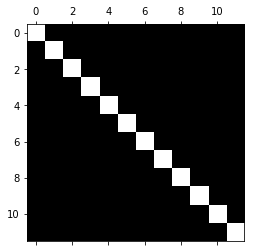

In [75]:
A= np.zeros((len(Hash), len(Hash)))
for i in  np.arange(len(Hash)):
    for j in np.arange(len(Hash)):
        A[i][j]= ((Hash[i+1][0] - Hash[j+1][0])**2 + (Hash[i+1][1] - Hash[j+1][1])**2)**(1./2.)
pyplot.spy(A)
pyplot.show()